In [ ]:

!pip install  transformers datasets
!pip install  captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.makedirs("plots", exist_ok=True)


In [ ]:
# Cell 1: Load data, model, and run inference over the entire test set


# 2) Imports
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 3) Load the test CSV and extract utterances
csv_path = "/content/test_sent_emo_cleaned_processed.csv"
df = pd.read_csv(csv_path)
# Assume column is named "utterance"; otherwise use first column
if "Utterance" in df.columns:
    utterances = df["Utterance"].tolist()
else:
    utterances = df.iloc[:, 0].tolist()

# 4) Load EmoBERTa tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
model.to(torch.device("cpu"))

# 5) Run inference on every utterance and store predicted indices
all_predictions = []
for text in utterances:
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    with torch.no_grad():
        logits = model(enc["input_ids"], attention_mask=enc["attention_mask"]).logits
        pred_idx = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()
    all_predictions.append(pred_idx)

print(f"Ran inference on {len(utterances)} utterances.")

# 6) Print out the first utterance and its predicted index
first_text = utterances[0]
first_pred_idx = all_predictions[0]
print(f"First utterance: {first_text}")
print(f"Predicted label index: {first_pred_idx}")


KeyboardInterrupt: 

Final Layer Attention Visualization

First utterance: "Push 'em out, push 'em out, way out!"
Predicted emotion: joy  (index 1)

Top 5 tokens by final-layer [CLS]→token attention:
            ! → 0.1834
         Push → 0.0806
         Ġway → 0.0695
            , → 0.0677
            , → 0.0608


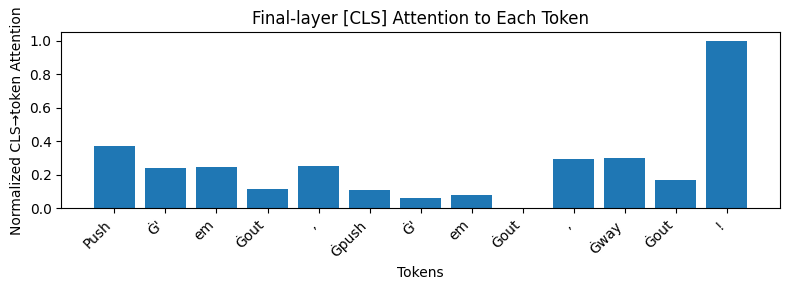

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

# 1) Read CSV and grab the first utterance
csv_path = "/content/test_sent_emo_cleaned_processed.csv"
df = pd.read_csv(csv_path)
if "Utterance" in df.columns:
    first_utterance = df["Utterance"].iloc[6]
else:
    first_utterance = df.iloc[0, 0]

# 2) Load EmoBERTa with output_attentions=True
config = AutoConfig.from_pretrained(
    "tae898/emoberta-base",
    output_attentions=True  # ensures attention weights are returned
)
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "tae898/emoberta-base",
    config=config
)
model.eval()
model.to(torch.device("cpu"))

# 3) Tokenize (pad/truncate to length 128)
encoding = tokenizer(
    first_utterance,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids = encoding["input_ids"]           # shape: (1, 128)
attention_mask = encoding["attention_mask"] # shape: (1, 128)

# 4) Forward pass → get logits & attentions
with torch.no_grad():
    outputs = model(
        input_ids,
        attention_mask=attention_mask
    )
    logits = outputs.logits                    # shape: (1, num_labels)
    attentions = outputs.attentions            # tuple of length num_layers

# 5) Compute predicted emotion label
pred_idx = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()
# id2label is a dict mapping index → emotion string
id2label = model.config.id2label
predicted_emotion = id2label[pred_idx]

print(f'First utterance: "{first_utterance}"')
print(f"Predicted emotion: {predicted_emotion}  (index {pred_idx})\n")

# 6) Extract “CLS → token” attention from the last layer
#    attentions[-1]: shape (1, num_heads, L, L); squeeze batch dim → (num_heads, L, L)
last_layer_attn = attentions[-1].squeeze(0)  # (num_heads, L, L)

# 7) For each head h, take the row i=0 (CLS position) → shape (num_heads, L)
cls_to_all = last_layer_attn[:, 0, :]         # (num_heads, L)
#  average over heads → (L,)
cls_importance = cls_to_all.mean(dim=0).cpu().numpy()

# 8) Map back to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())  # length L=128

# 9) Pair (token, score), filter out special tokens & [PAD]
pairs = [
    (tok, float(score))
    for tok, score in zip(tokens, cls_importance)
    if tok not in tokenizer.all_special_tokens and tok != "[PAD]"
]

# 10) Sort descending by attention score and print top 5
pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
print("Top 5 tokens by final-layer [CLS]→token attention:")
for tok, score in pairs_sorted[:5]:
    print(f"   {tok:>10} → {score:.4f}")

# 11) (Optional) Bar chart of normalized scores over all tokens
words = [tok for tok, _ in pairs]
scores = np.array([s for _, s in pairs])
# Normalize to [0,1]:
norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

plt.figure(figsize=(max(8, len(words)*0.3), 3))
plt.bar(range(len(words)), norm)
plt.xticks(range(len(words)), words, rotation=45, ha="right")
plt.ylabel("Normalized CLS→token Attention")
plt.xlabel("Tokens")
plt.title("Final-layer [CLS] Attention to Each Token")
plt.tight_layout()
plt.savefig("plots/cell2_cls_attention.png", bbox_inches="tight")

plt.show()


Layer Integrated Gradients

Number of layers: 13, number of axes slots: 15


<ipython-input-35-52559fd4b568>:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
<ipython-input-35-52559fd4b568>:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
<ipython-input-35-52559fd4b568>:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
<ipython-input-35-52559fd4b568>:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
<ipython-input-35-52559fd4b568>:104: UserWarning: set_ticklabels() should only be used with a fixed number o

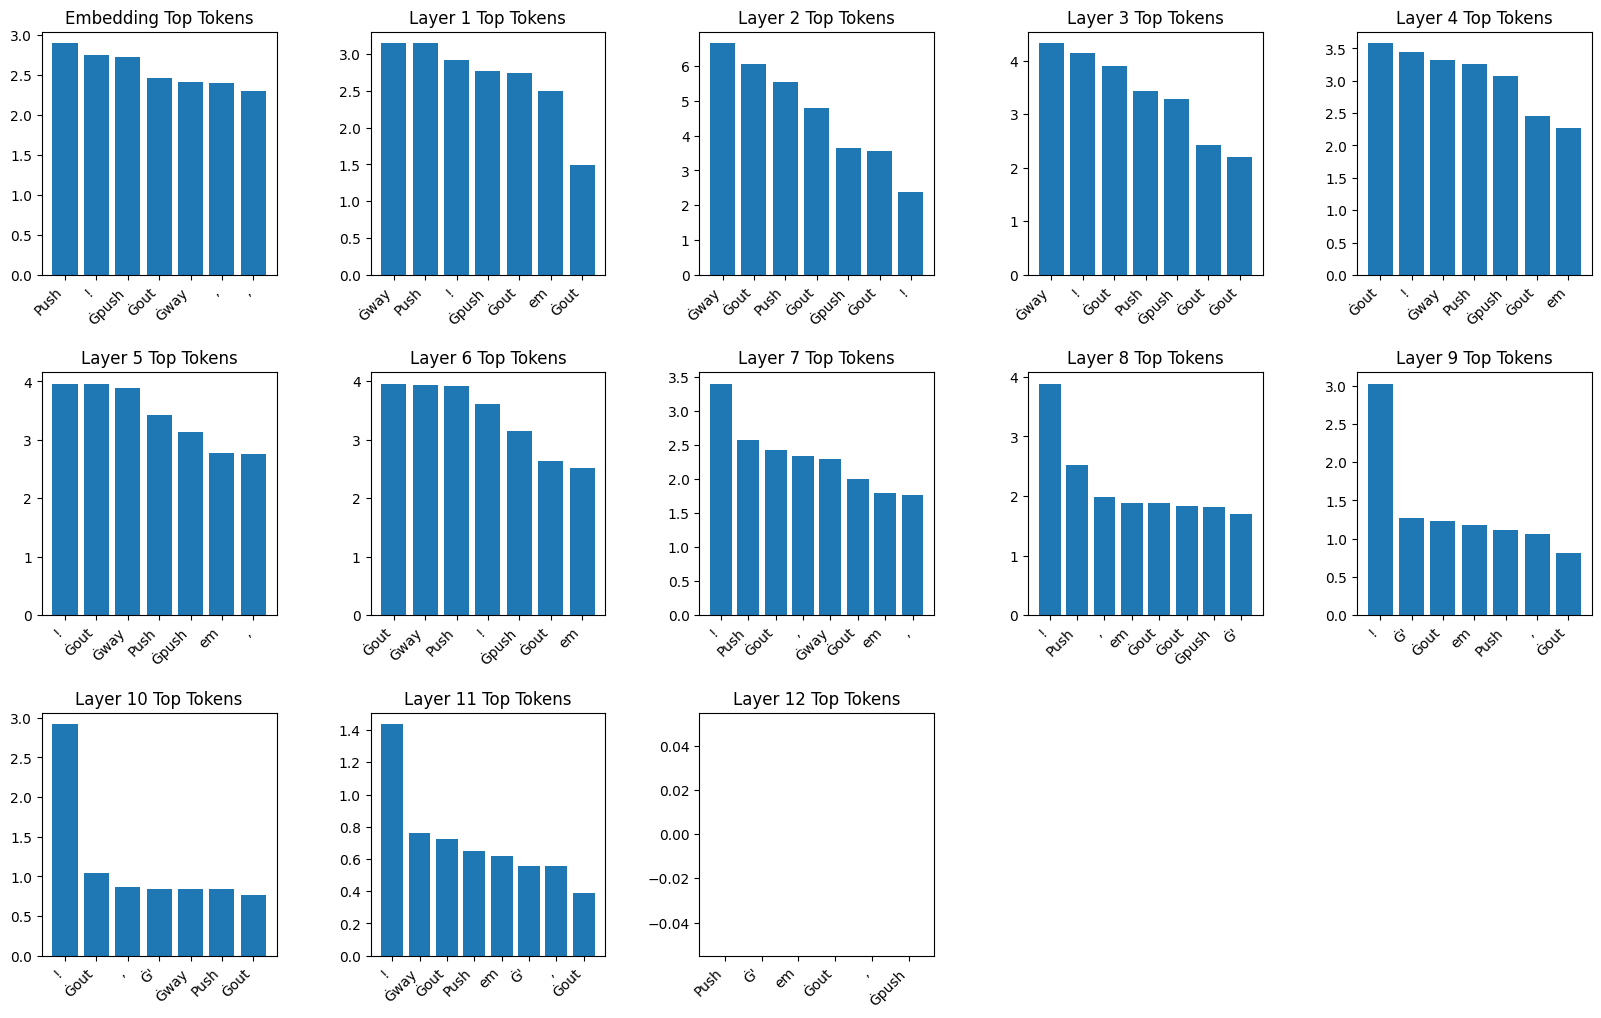

In [ ]:
import os

import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import LayerIntegratedGradients

# 1) Φόρτωση Δεδομένων & Μοντέλου
df = pd.read_csv("/content/test_sent_emo_cleaned_processed.csv")
texts = df["Utterance"].tolist()

tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")

# Βεβαιωνόμαστε ότι δουλεύουμε σε CPU
device = torch.device("cpu")

# Αποφεύγουμε να καλούμε model.to(device) με GPU
model.to(device)

# 2) Συνάρτηση forward_from_embs
def forward_from_embs(emb, attn_mask):
    out = model(inputs_embeds=emb, attention_mask=attn_mask).logits
    return out

# 3) Επιλογή ενός παραδείγματος κειμένου
text = texts[6]
enc = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids = enc["input_ids"].to(device)
attention_mask = enc["attention_mask"].to(device)

# 4) Υπολογισμός embeddings και baseline embeddings
embeds = model.roberta.embeddings(input_ids)
pad_id = tokenizer.pad_token_id
baseline_ids = torch.full_like(input_ids, pad_id)
baseline_embeds = model.roberta.embeddings(baseline_ids)

# 5) Προβλεπόμενη κλάση
with torch.no_grad():
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
    pred_idx = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()

# 6) Δημιουργία λίστας στρωμάτων: πρώτα το embedding, μετά τα 12 encoder layers
layers = [model.roberta.embeddings] + [model.roberta.encoder.layer[i].output for i in range(len(model.roberta.encoder.layer))]
num_layers = len(layers)  # 13 επίπεδα συνολικά

token_ids = input_ids.squeeze(0).cpu().tolist()
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# 7) Δημιουργία υποπλοκών: 3x5 = 15 θέσεις (θα μείνουν κενές 2)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()

print(f"Number of layers: {num_layers}, number of axes slots: {len(axes)}")

for idx, target_layer in enumerate(layers):
    # Όρισμα LayerIG για κάθε layer
    lig = LayerIntegratedGradients(lambda emb, mask: forward_from_embs(emb, mask)[:, pred_idx], target_layer)

    # Υπολογισμός attribution
    attributions = lig.attribute(
    inputs=embeds,
    baselines=baseline_embeds,
    additional_forward_args=(attention_mask,),
    n_steps=50
    )


    # Απόδοση σε επίπεδο token
    attributions = attributions.squeeze(0)  # [seq_len, hidden_dim]
    token_attr = attributions.abs().sum(dim=-1).cpu().tolist()  # [seq_len]

    # Φιλτράρισμα ειδικών tokens
    plot_tokens = []
    plot_scores = []
    for tok, score in zip(tokens, token_attr):
        if tok in {tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token}:
            continue
        plot_tokens.append(tok)
        plot_scores.append(score)

    # Top 10 tokens
    top_pairs = sorted(zip(plot_tokens, plot_scores), key=lambda x: x[1], reverse=True)[:10]
    if top_pairs:
        top_tokens, top_scores = zip(*top_pairs)
    else:
        top_tokens, top_scores = [], []

    # Σχεδίαση bar plot
    if idx >= len(axes):  # αν τυχόν έχουμε περισσότερα layers από subplots
        break
    ax = axes[idx]
    ax.bar(top_tokens, top_scores)
    layer_name = "Embedding" if idx == 0 else f"Layer {idx}"
    ax.set_title(f"{layer_name} Top Tokens")
    ax.set_xticklabels(top_tokens, rotation=45, ha="right")

# Αφαίρεση τυχόν κενών υποπλοκών
for j in range(num_layers, len(axes)):
    fig.delaxes(axes[j])

# Αυξημένες αποστάσεις μεταξύ υποπλοκών
plt.subplots_adjust(hspace=0.4, wspace=0.4)
# 6) Αποθήκευση όλου του figure σε αρχείο
fig.savefig("plots/all_layers_top_tokens.png", dpi=200, bbox_inches="tight")

# 7) Εμφάνιση στην οθόνη
plt.show()

First utterance: "Why do all you’re coffee mugs have numbers on the bottom?"

Predicted emotion: surprise  (index 2)

Convergence delta: 0.084516

Raw BPE tokens (repr):
 00 │ '<s>'         → attribution -0.0057
 01 │ 'Why'         → attribution 1.2739
 02 │ 'Ġdo'         → attribution 0.0420
 03 │ 'Ġall'        → attribution -0.4142
 04 │ 'Ġyou'        → attribution -0.1745
 05 │ 'âĢ'          → attribution 0.2070
 06 │ 'Ļ'           → attribution 0.4937
 07 │ 're'          → attribution 0.6899
 08 │ 'Ġcoffee'     → attribution 0.1446
 09 │ 'Ġm'          → attribution -0.2459
 10 │ 'ugs'         → attribution 0.0839
 11 │ 'Ġhave'       → attribution 0.2321
 12 │ 'Ġnumbers'    → attribution 0.1406
 13 │ 'Ġon'         → attribution 0.4972
 14 │ 'Ġthe'        → attribution 0.1393
 15 │ 'Ġbottom'     → attribution 0.0426
 16 │ '?'           → attribution 1.7607
 17 │ '</s>'        → attribution 0.0704
 18 │ '<pad>'       → attribution 0.0000
 19 │ '<pad>'       → attribution 0.0000
 20 │ 

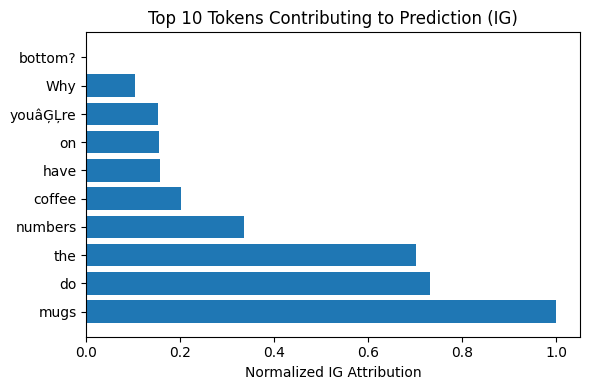

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import LayerIntegratedGradients

# 1) Read the CSV and grab the first utterance
csv_path = "/content/test_sent_emo_cleaned_processed.csv"
df = pd.read_csv(csv_path, encoding="utf-8")

if "Utterance" in df.columns:
    first_utterance = df["Utterance"].iloc[0]
else:
    first_utterance = df.iloc[0, 0]

print(f'First utterance: "{first_utterance}"\n')

# 2) Load EmoBERTa (we don't strictly need output_attentions=True for IG, but it's okay)
config = AutoConfig.from_pretrained("tae898/emoberta-base", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "tae898/emoberta-base",
    config=config
)
model.eval()

# 3) Choose device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4) Tokenize with max_length=64 to reduce memory usage
encoding = tokenizer(
    first_utterance,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=64
)
input_ids = encoding["input_ids"].to(device)           # shape: (1, 64)
attention_mask = encoding["attention_mask"].to(device) # shape: (1, 64)

# 5) Run a forward pass to get the model’s predicted class index
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits               # (1, num_labels)
    probs = torch.softmax(logits, dim=-1)
    pred_idx = torch.argmax(probs, dim=-1).item()

id2label = model.config.id2label
predicted_emotion = id2label[pred_idx]
print(f"Predicted emotion: {predicted_emotion}  (index {pred_idx})\n")

# 6) Define a forward function for LayerIntegratedGradients
#    It should accept exactly (input_ids, attention_mask) and return the scalar logit for pred_idx
def forward_func(input_ids_, attention_mask_):
    """
    input_ids_:      (1, seq_len)
    attention_mask_: (1, seq_len)
    Returns:         (1,) tensor = logit for the predicted class (pred_idx)
    """
    out = model(input_ids_, attention_mask=attention_mask_)
    return out.logits[:, pred_idx]  # shape: (1,)

# 7) Build a baseline of all [MASK] tokens (instead of [PAD]) to reduce function-word bias
mask_id = tokenizer.mask_token_id
baseline_ids = torch.full_like(input_ids, mask_id).to(device)

# 8) Instantiate LayerIntegratedGradients with respect to the embedding layer
lig = LayerIntegratedGradients(
    forward_func,
    model.roberta.embeddings.word_embeddings
)

# 9) Compute attributions
#    - inputs = actual input_ids
#    - baselines = baseline_ids (all [MASK] tokens)
#    - additional_forward_args = (attention_mask,)
#    - return_convergence_delta = True
#    - n_steps = 50 for smoother approximation
attributions, delta = lig.attribute(
    inputs=input_ids,
    baselines=baseline_ids,
    additional_forward_args=(attention_mask,),
    return_convergence_delta=True,
    n_steps=50
)
# attributions: shape (1, seq_len, hidden_dim)
# delta: single tensor (convergence measure)

# 10) Sum attributions across the hidden‐dimension → one scalar per token
#     → shape (seq_len,)
token_attributions = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()

print(f"Convergence delta: {delta.item():.6f}\n")

# 11) Convert input IDs back to BPE tokens (length = 64)
raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().tolist())

# 12) Print out each raw token with repr(...) so we can see its exact Unicode form
print("Raw BPE tokens (repr):")
for i, tok in enumerate(raw_tokens):
    print(f" {i:02d} │ {repr(tok):<12}  → attribution {token_attributions[i]:.4f}")
print()

# 13) Pair (token, attribution_score) but filter out any special tokens & [PAD]
pairs = []
for tok, score in zip(raw_tokens, token_attributions):
    # `tokenizer.all_special_tokens` contains "<s>", "</s>", "<pad>", "<mask>", "<unk>", etc.
    if tok not in tokenizer.all_special_tokens and tok != tokenizer.pad_token:
        pairs.append((tok, float(score)))

# 14) Merge BPE subwords into full words, summing their scores
def merge_bpe_subwords(token_score_pairs):
    """
    Merges RoBERTa byte‐BPE tokens into complete words.
    Rule: If a token starts with the single character "Ġ" (U+0120),
    that indicates the start of a new word (strip off "Ġ" to begin).
    Otherwise, it is a continuation of the previous word.
    """
    merged = []
    current_word = ""
    current_score = 0.0

    for tok, sc in token_score_pairs:
        if tok.startswith("Ġ"):
            # Commit the previous word if it exists
            if current_word:
                merged.append((current_word, current_score))
            # Start a brand‐new word: strip off the leading U+0120 "Ġ"
            current_word = tok.replace("Ġ", "", 1)
            current_score = sc
        else:
            # Continuation subword: append literally, accumulate score
            current_word += tok
            current_score += sc

    # Append the last word
    if current_word:
        merged.append((current_word, current_score))
    return merged

merged = merge_bpe_subwords(pairs)

# 15) Sort merged words by attribution descending and print the top 10
merged_sorted = sorted(merged, key=lambda x: x[1], reverse=True)

print("Top 10 words by Integrated Gradients attribution (after merging):")
for word, score in merged_sorted[:10]:
    print(f"   {word:>12} → {score:.4f}")

# 16) (Optional) Plot a horizontal bar chart of those top 10 (normalized to [0,1])
topk = merged_sorted[:10]
words = [w for w, _ in topk]
scores_topk = np.array([s for _, s in topk])
# Normalize so the largest maps to 1.0
norm_scores = (scores_topk - scores_topk.min()) / (scores_topk.max() - scores_topk.min() + 1e-10)

plt.figure(figsize=(6, 4))
plt.barh(range(len(words))[::-1], norm_scores[::-1], align="center")
plt.yticks(range(len(words)), words[::-1])
plt.xlabel("Normalized IG Attribution")
plt.title("Top 10 Tokens Contributing to Prediction (IG)")
plt.tight_layout()
plt.show()


In [ ]:
!pip install captum

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# 1) (Ξανα)φορτώνουμε το CSV και βγάζουμε τη λίστα των κειμένων
df = pd.read_csv("/content/test_sent_emo_cleaned_processed.csv")
texts = df["Utterance"].tolist()

# 2) Φορτώνουμε ξανά το tokenizer και το μοντέλο
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-large")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3) Ορίζουμε (ξανά) ακριβώς τη συνάρτηση με το σωστό όνομα:
def explain_predicted_with_embs(text, tokenizer, model, device, max_length=128, n_steps=20):
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)         # LongTensor [1, max_length]
    attention_mask = enc["attention_mask"].to(device)

    # (β) Προβλεπόμενη κλάση
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits  # [1, num_labels]
        probs = torch.softmax(logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

    # (γ) Πραγματικά embeddings για το input
    embeds = model.roberta.embeddings(input_ids)     # [1, max_length, hidden_dim]

    # (δ) Baseline: όλοι PAD tokens
    pad_id = tokenizer.pad_token_id
    baseline_ids = torch.full_like(input_ids, pad_id)       # [1, max_length]
    baseline_embeds = model.roberta.embeddings(baseline_ids)  # [1, max_length, hidden_dim]

    # (ε) Forward που δέχεται απευθείας embeddings + attention_mask → logit[pred_idx]
    def forward_from_embs(emb, attn_mask):
        out = model(
            inputs_embeds=emb,
            attention_mask=attn_mask
        ).logits               # [1, num_labels]
        return out[:, pred_idx]  # [1] (logit μόνο για την pred_idx κλάση)

    # (στ) Integrated Gradients
    ig = IntegratedGradients(forward_from_embs)
    attributions, delta = ig.attribute(
        inputs=embeds,
        baselines=baseline_embeds,
        additional_forward_args=(attention_mask,),
        return_convergence_delta=True,
        n_steps=n_steps
    )

    # (ζ) Μετατροπή από [1, max_length, hidden_dim] → [max_length]
    attributions = attributions.squeeze(0)                       # [max_length, hidden_dim]
    token_level_attr = attributions.abs().sum(dim=-1).cpu().tolist()  # [max_length]

    # (η) Ανακτούμε tokens για να τα ταιριάξουμε με τα scores
    token_ids = input_ids.squeeze(0).cpu().tolist()  # length = max_length
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return tokens, token_level_attr


# 4) Τώρα τρέχουμε τον βρόχο πάνω σε όλα τα κείμενα χρησιμοποιώντας
#    ακριβώς το explain_predicted_with_embs
rows = []
emotions = df["Emotion"].tolist()
for text, emotion in zip(texts, emotions):
    tokens, attr_vals = explain_predicted_with_embs(text, tokenizer, model, device)
    for tok, val in zip(tokens, attr_vals):
        # Φιλτράρουμε ειδικά tokens
        if tok in {tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token}:
            continue
        rows.append({
            "token": tok,
            "attribution": val,
            "emotion": emotion
        })

df_all = pd.DataFrame(rows)
print(df_all.shape)   # π.χ. (αρκετές χιλιάδες, 3)
print(df_all.head(10))

# Παράδειγμα: Θέλουμε το emotion "joy"
target_emotion = "joy"

# Φιλτράρουμε μόνο τις σειρές του df_all με emotion == "joy"
df_joy = df_all[df_all["emotion"] == target_emotion]

# Ομαδοποιούμε κατά token και υπολογίζουμε τη μέση τιμή attribution
df_summary_joy = (
    df_joy
    .groupby("token")["attribution"]
    .mean()
    .reset_index(name="mean_attribution")
)

# Ταξινομούμε σε φθίνουσα σειρά και κρατάμε τα top 10
df_top_joy = df_summary_joy.sort_values(by="mean_attribution", ascending=False).head(10)
print(df_top_joy)


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# 1) Load your CSV and texts
df = pd.read_csv("/content/test_sent_emo_cleaned_processed.csv")
texts = df["Utterance"].tolist()  # list of strings

# 2) Load EmoBERTa
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-large")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3) Attribution function that uses embeddings directly
def explain_predicted_with_embs(text, tokenizer, model, device, max_length=128, n_steps=20):
    # (a) Tokenize to get input_ids and attention_mask
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)         # LongTensor [1, max_length]
    attention_mask = enc["attention_mask"].to(device)

    # (b) Run one forward pass to get predicted class index
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits  # [1, num_labels]
        probs = torch.softmax(logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

    # (c) Compute the actual embedding of this input (FloatTensor)
    #     If EmoBERTa is RoBERTa-based, its embeddings live under model.roberta.embeddings
    embeds = model.roberta.embeddings(input_ids)     # FloatTensor [1, max_length, hidden_dim]

    # (d) Build a “baseline” of all-[PAD] IDs, then get its embeddings
    pad_id = tokenizer.pad_token_id
    baseline_ids = torch.full_like(input_ids, pad_id)  # LongTensor [1, max_length]
    baseline_embeds = model.roberta.embeddings(baseline_ids)  # FloatTensor [1, max_length, hidden_dim]

    # (e) Define a forward function that takes embeddings + attention_mask → logit for pred_idx
    def forward_from_embs(emb, attn_mask):
        # emb: FloatTensor [1, max_length, hidden_dim]
        # attn_mask: LongTensor [1, max_length]
        out = model(
            inputs_embeds=emb,       # directly pass embedding vectors
            attention_mask=attn_mask
        ).logits                  # [1, num_labels]
        return out[:, pred_idx]   # [1], the logit for class=pred_idx

    # (f) Run IntegratedGradients over embeddings
    ig = IntegratedGradients(forward_from_embs)
    attributions, delta = ig.attribute(
        inputs=embeds,                     # FloatTensor baseline → real embedding
        baselines=baseline_embeds,         # FloatTensor [PAD]-only embedding
        additional_forward_args=(attention_mask,),
        return_convergence_delta=True,
        n_steps=n_steps                     # e.g. 20 or 50 steps of interpolation
    )

    # (g) Convert attributions from shape [1, max_length, hidden_dim] → [max_length]
    #     by summing across the embedding‐dimension
    #     (you could also take L2 norm or any other reduction, but sum is common)
    attributions = attributions.squeeze(0)                   # [max_length, hidden_dim]
    token_level_attr = attributions.abs().sum(dim=-1).cpu().tolist()  # [max_length] floats

    # (h) Recover token strings to align with those scores
    token_ids = input_ids.squeeze(0).cpu().tolist()        # length=max_length
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return tokens, token_level_attr

# 4) Example: run this on the first utterance and build a DataFrame of (token, attribution):
tokens0, attrs0 = explain_predicted_with_embs(texts[0], tokenizer, model, device)

# Build a DataFrame for demonstration (filter out special tokens)
rows = []
for tok, val in zip(tokens0, attrs0):
    if tok in {tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token}:
        continue
    rows.append({"token": tok, "attribution": val})

import pandas as pd
df_tok0 = pd.DataFrame(rows)
print("First utterance token attributions:\n")
print(df_tok0)


tokenizer_config.json:   0%|          | 0.00/408 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

First utterance token attributions:

       token  attribution
0        Why     2.108910
1        Ġdo     2.082232
2       Ġall     4.300513
3       Ġyou     1.672208
4         âĢ     1.759893
5          Ļ     1.980521
6         re     2.038177
7    Ġcoffee     2.981331
8         Ġm     1.552305
9        ugs     2.982063
10     Ġhave     2.996512
11  Ġnumbers     3.983790
12       Ġon     3.401843
13      Ġthe     1.926494
14   Ġbottom     2.878564
15         ?     2.142095


LIME

Example utterance:
Why do all you’re coffee mugs have numbers on the bottom?

Model’s predicted class: surprise  (index 2)

Top tokens contributing to "surprise" (LIME):
       Why  →  0.4075
       you  →  0.2104
        re  →  0.1127
        on  →  0.1020
   numbers  →  0.1010
       all  →  -0.0991
        do  →  -0.0728
      have  →  0.0674


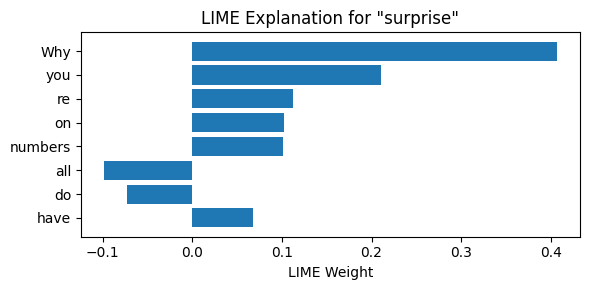

In [ ]:
# 0) If you haven’t installed LIME already, run this once:
!pip install lime

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

# 1) Load your CSV and grab the first utterance
csv_path = "/content/test_sent_emo_cleaned_processed.csv"
df = pd.read_csv(csv_path, encoding="utf-8")

if "Utterance" in df.columns:
    example_text = df["Utterance"].iloc[0]
else:
    example_text = df.iloc[0, 0]

print(f"Example utterance:\n{example_text}\n")

# 2) Load the tokenizer & model (EmoBERTa)
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3) Build a predict_proba function for LIME
#    It should accept a list of raw strings, tokenize them, run the model,
#    and return a NumPy array of shape (n_samples, n_labels) of probabilities.

def predict_proba(texts: list[str]) -> np.ndarray:
    """
    texts: list of raw utterance strings, e.g. ["I’m so excited", "I feel sad"]
    returns: (n_texts, num_labels) NumPy array of softmax probabilities
    """
    # 3a) Tokenize with padding & truncation
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    # 3b) Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # (batch_size, num_labels)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs  # shape: (n_texts, num_labels)

# 4) Prepare class names (id2label mapping)
id2label = model.config.id2label  # a dict {0: "joy", 1: "sadness", …}
class_names = [id2label[i] for i in range(len(id2label))]

# 5) Initialize the LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# 6) Explain the example_text
#    - num_features: how many tokens/ngrams you want in the explanation
#    - labels: tuple of label indices you want explanations for.
#      If you pass labels=(pred_idx,), LIME will highlight tokens that push
#      the prediction towards the model’s own predicted class.
#      If you pass labels=(0,1,2,…), it will compute for each class.
#    Here we pick the model’s predicted class for a focused explanation.

# 6a) First get the model’s predicted index
probs_example = predict_proba([example_text])  # shape (1, num_labels)
pred_idx = int(np.argmax(probs_example, axis=1)[0])
predicted_label = id2label[pred_idx]
print(f"Model’s predicted class: {predicted_label}  (index {pred_idx})\n")

# 6b) Run LIME’s explanation
num_lime_features = 8  # you can increase or decrease
explanation = explainer.explain_instance(
    example_text,
    predict_proba,
    num_features=num_lime_features,
    labels=(pred_idx,)
)

# 7) Extract and print the token contributions for the predicted class
print(f"Top tokens contributing to \"{predicted_label}\" (LIME):")
for token, weight in explanation.as_list(label=pred_idx):
    print(f"{token:>10}  →  {weight:.4f}")

# 8) (Optional) Visualize the explanation in notebook
#    This will show a colorful text plot if you’re running in Jupyter/Colab.

# explanation.show_in_notebook(text=True)

# 9) If you want a static bar chart of those LIME weights, do:
import matplotlib.pyplot as plt

lime_list = explanation.as_list(label=pred_idx)  # [(token, weight), ...]
tokens_lime = [t for t, _ in lime_list]
weights_lime = [w for _, w in lime_list]

plt.figure(figsize=(6, 3))
y_pos = np.arange(len(tokens_lime))
plt.barh(y_pos, weights_lime[::-1], align='center')
plt.yticks(y_pos, tokens_lime[::-1])
plt.xlabel("LIME Weight")
plt.title(f"LIME Explanation for \"{predicted_label}\"")
plt.tight_layout()
plt.savefig("plots/cell6_lime_single_example.png", bbox_inches="tight")

plt.show()


Loaded 200 utterances for explanation.

Computing LIME explanations for each utterance and aggregating token weights...

  Processed 50/200 utterances
  Processed 100/200 utterances
  Processed 150/200 utterances
  Processed 200/200 utterances

Aggregation complete.



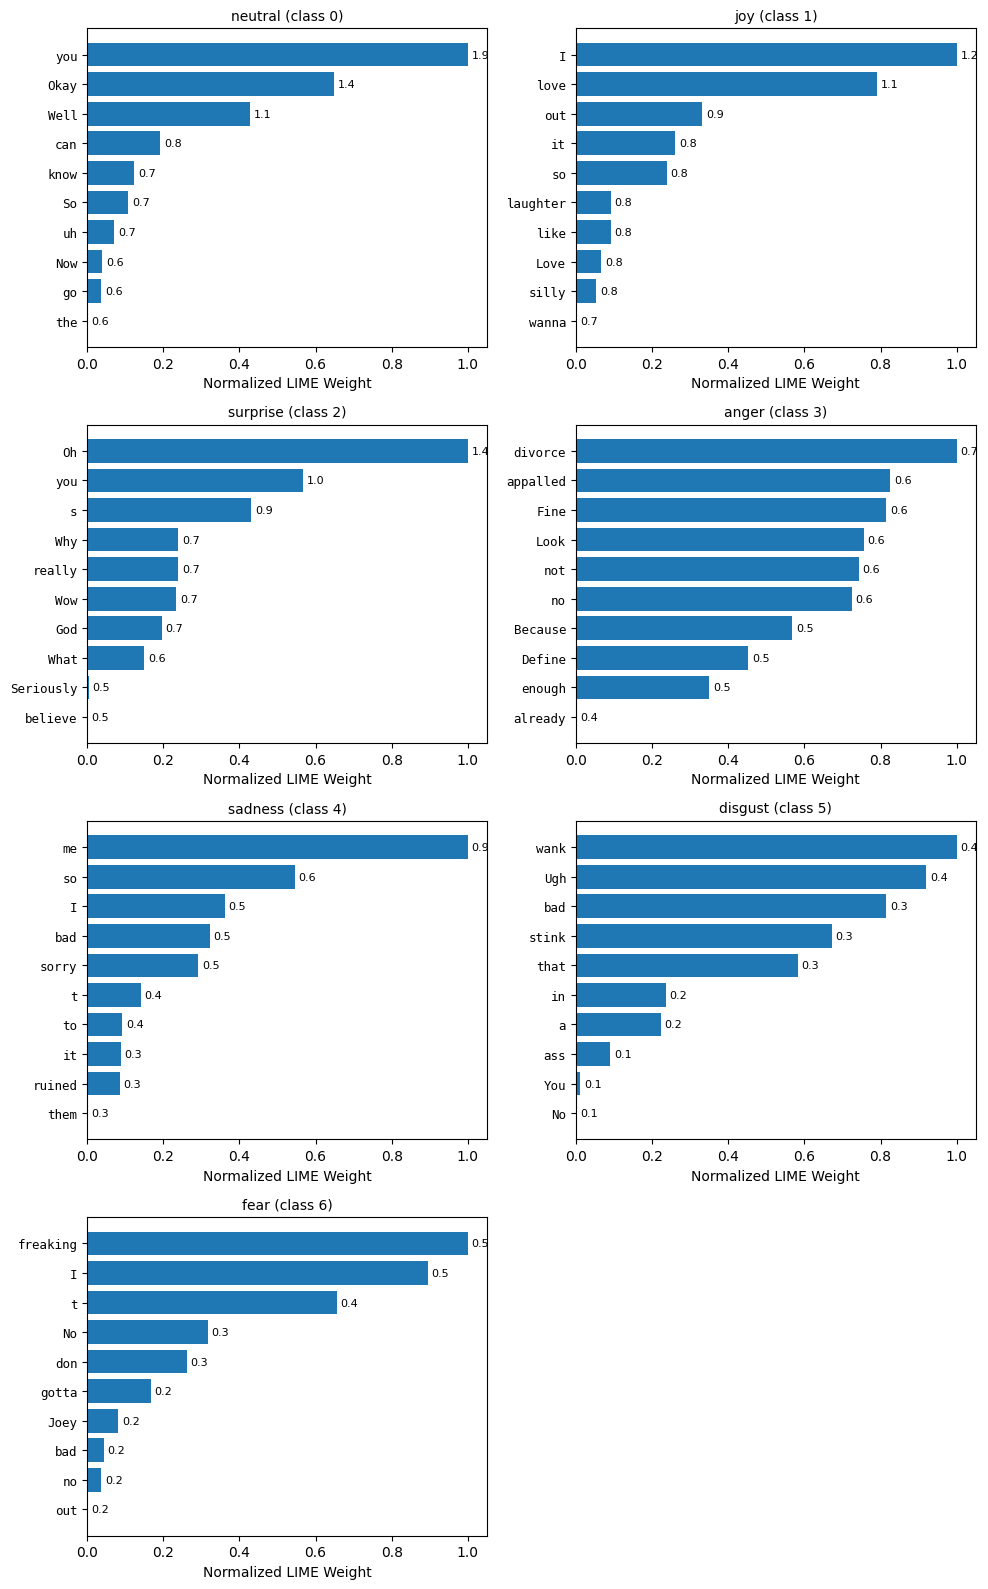

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

# ============================
# 1) Configuration Parameters
# ============================
CSV_PATH        = "/content/test_sent_emo_cleaned_processed.csv"  # Path to your CSV
N_EXAMPLES      = 200     # Number of utterances to explain
NUM_FEATURES    = 6       # Number of top tokens LIME returns per class per utterance
NUM_SAMPLES     = 300     # Number of perturbed samples LIME uses (tradeoff speed vs. stability)
TOP_K           = 10      # Number of top tokens to display per class in final plots
MAX_SEQ_LENGTH  = 128     # Max token length for tokenizer

# ============================
# 2) Load Utterances
# ============================
df = pd.read_csv(CSV_PATH, encoding="utf-8")
# Take the first N_EXAMPLES utterances (or sample randomly if preferred)
utterances = df["Utterance"].tolist()[:N_EXAMPLES]

print(f"Loaded {len(utterances)} utterances for explanation.\n")

# ============================
# 3) Load Tokenizer & Model
# ============================
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model     = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Build mapping of class indices to labels
id2label    = model.config.id2label
class_names = [id2label[i] for i in range(len(id2label))]
num_classes = len(class_names)

# ============================
# 4) Define predict_proba for LIME
# ============================
def predict_proba(texts: list[str]) -> np.ndarray:
    """
    Given a list of raw utterance strings, return an (n_samples, n_labels) array of softmax probabilities.
    """
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQ_LENGTH
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs  = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# ============================
# 5) Initialize LIME Explainer
# ============================
explainer = LimeTextExplainer(class_names=class_names)

# ============================
# 6) Aggregate LIME Weights
# ============================
# Structure: aggregated_weights[class_idx][token] = sum of LIME weights over all utterances
aggregated_weights = {i: defaultdict(float) for i in range(num_classes)}

print("Computing LIME explanations for each utterance and aggregating token weights...\n")
for idx, text in enumerate(utterances):
    # Explain for all classes
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=NUM_FEATURES,
        labels=tuple(range(num_classes)),
        num_samples=NUM_SAMPLES
    )
    # For each class, get top NUM_FEATURES (token, weight) pairs and accumulate
    for cls_idx in range(num_classes):
        for token, weight in explanation.as_list(label=cls_idx):
            aggregated_weights[cls_idx][token] += weight
    # Progress update
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{N_EXAMPLES} utterances")

print("\nAggregation complete.\n")

# ============================
# 7) Plot Aggregated Top Tokens per Class
# ============================
# Determine grid size: 2 columns, enough rows to fit all classes
n_cols = 2
n_rows = (num_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for cls_idx in range(num_classes):
    ax = axes[cls_idx]
    cls_name = class_names[cls_idx]
    token_scores = aggregated_weights[cls_idx]

    # Sort tokens by descending aggregated weight
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_tokens[:TOP_K]
    if not topk:
        ax.set_visible(False)
        continue

    tokens, weights = zip(*topk)
    arr = np.array(weights)
    # Normalize to [0,1] for bar lengths
    norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, norm, align='center', color='tab:blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9, family="monospace")
    ax.invert_yaxis()  # Highest weight on top
    ax.set_title(f"{cls_name} (class {cls_idx})", fontsize=10)
    ax.set_xlabel("Normalized LIME Weight")

    # Annotate raw aggregated weights next to bars
    for i, (_, w) in enumerate(topk):
        ax.text(norm[i] + 0.01, i, f"{w:.1f}", va='center', fontsize=8)

# Hide any unused subplots
for j in range(num_classes, n_rows * n_cols):
    fig.delaxes(axes[j])
plt.savefig("plots/lime_over_200utt_sum.png", bbox_inches="tight")

plt.tight_layout()
plt.show()


Loaded 200 utterances for LIME explanation.

Computing LIME explanations and aggregating weights...

  Processed 50/200 utterances
  Processed 100/200 utterances
  Processed 150/200 utterances
  Processed 200/200 utterances

Aggregation complete.



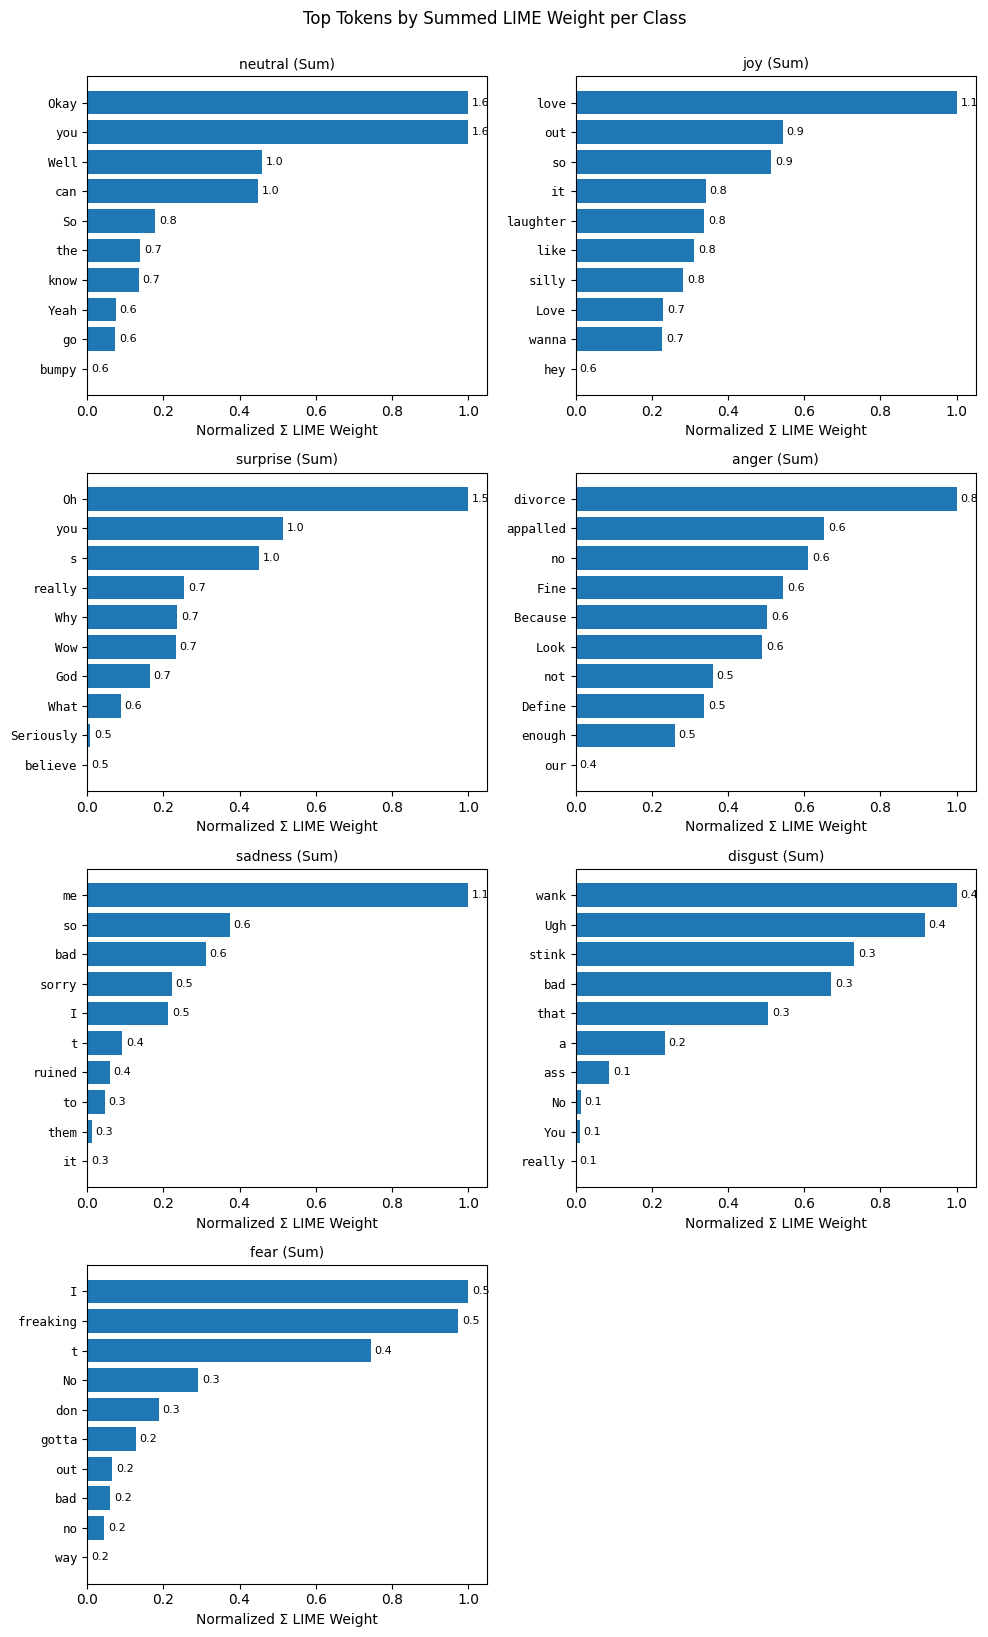

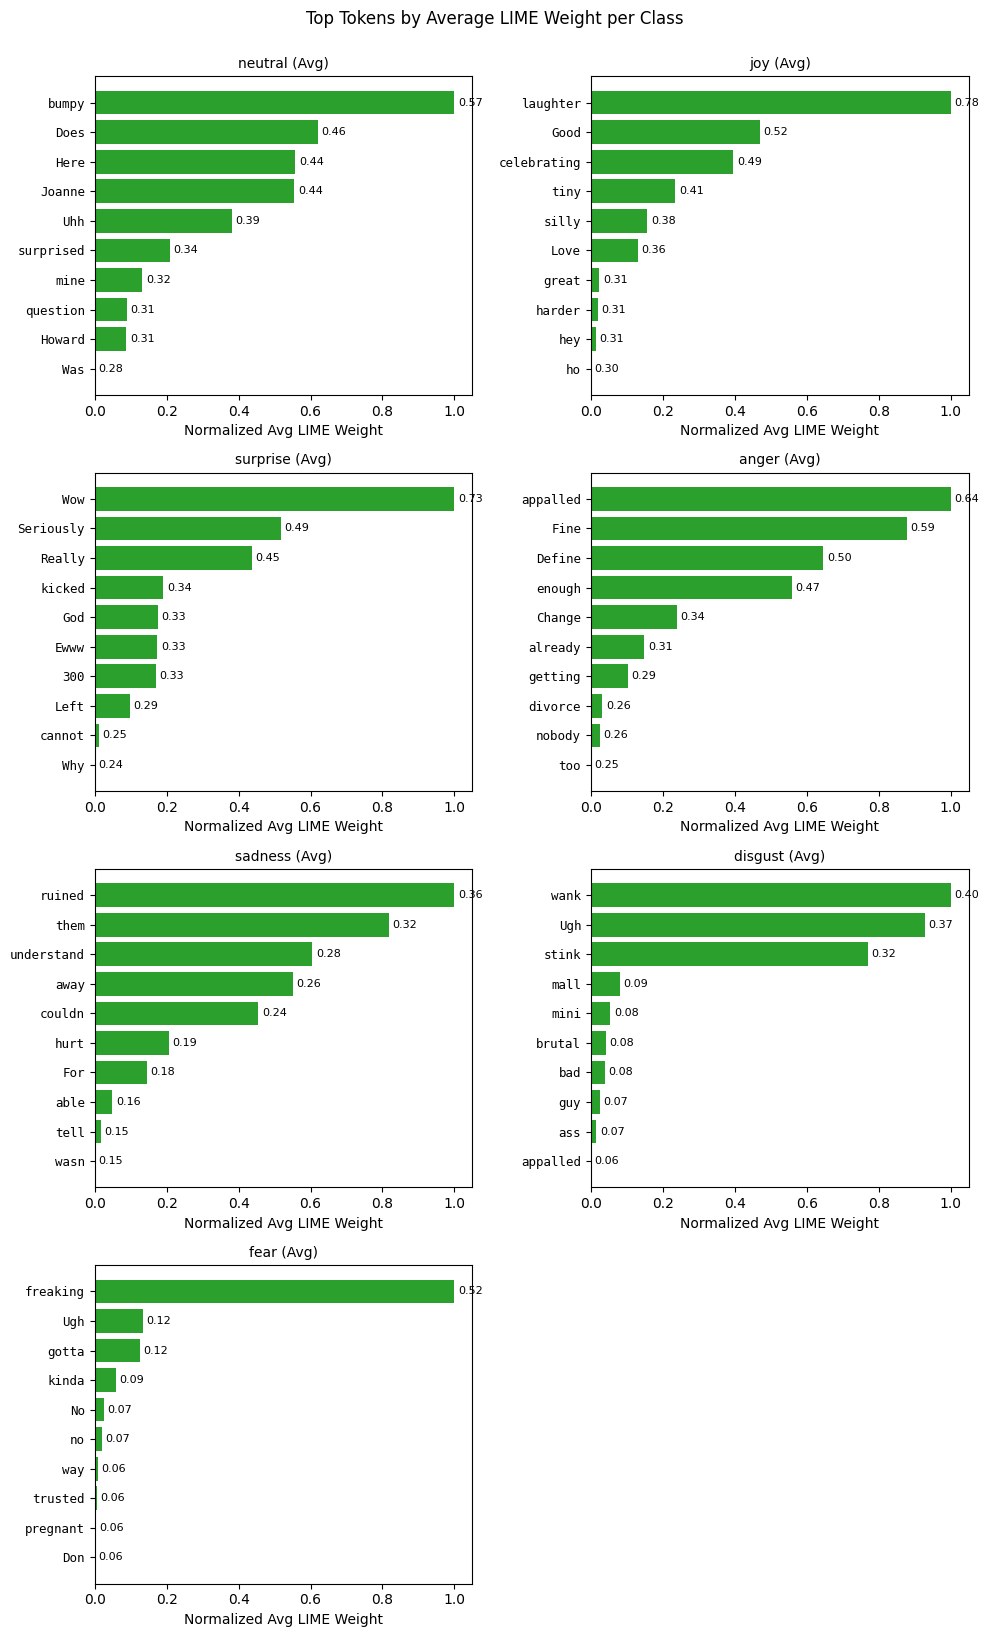

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

# ============================
# 1) Configuration Parameters
# ============================
CSV_PATH        = "/content/test_sent_emo_cleaned_processed.csv"  # Path to your CSV
N_EXAMPLES      = 200     # Number of utterances to explain
NUM_FEATURES    = 6       # How many top tokens LIME returns per class per utterance
NUM_SAMPLES     = 300     # LIME’s number of perturbed samples (tradeoff: speed vs. stability)
TOP_K           = 10      # Top tokens to display per class in final plots
MAX_SEQ_LENGTH  = 128     # Max token length for tokenizer

# ============================
# 2) Load Utterances
# ============================
df = pd.read_csv(CSV_PATH, encoding="utf-8")
utterances = df["Utterance"].tolist()[:N_EXAMPLES]
print(f"Loaded {len(utterances)} utterances for LIME explanation.\n")

# ============================
# 3) Load Tokenizer & Model
# ============================
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model     = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Map class indices to labels
id2label    = model.config.id2label
class_names = [id2label[i] for i in range(len(id2label))]
num_classes = len(class_names)

# ============================
# 4) Define predict_proba for LIME
# ============================
def predict_proba(texts: list[str]) -> np.ndarray:
    """
    Given a list of raw utterance strings, return an (n_samples, n_labels) array
    of softmax probabilities from the model.
    """
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQ_LENGTH
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs  = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# ============================
# 5) Initialize LIME Explainer
# ============================
explainer = LimeTextExplainer(class_names=class_names)

# ============================
# 6) Aggregate LIME Weights & Counts
# ============================
# We want both sum of weights and count of occurrences per token/class
sum_weights       = {i: defaultdict(float) for i in range(num_classes)}
count_occurrences = {i: defaultdict(int)   for i in range(num_classes)}

print("Computing LIME explanations and aggregating weights...\n")
for idx, text in enumerate(utterances):
    # Explain for all classes simultaneously
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=NUM_FEATURES,
        labels=tuple(range(num_classes)),
        num_samples=NUM_SAMPLES
    )
    # For each class, accumulate sum of weights and count occurrences
    for cls_idx in range(num_classes):
        for token, weight in explanation.as_list(label=cls_idx):
            sum_weights[cls_idx][token] += weight
            count_occurrences[cls_idx][token] += 1
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{N_EXAMPLES} utterances")
print("\nAggregation complete.\n")

# ============================
# 7) Compute Average Weights
# ============================
avg_weights = {i: {} for i in range(num_classes)}
for cls_idx in range(num_classes):
    for token, total in sum_weights[cls_idx].items():
        cnt = count_occurrences[cls_idx][token]
        avg_weights[cls_idx][token] = total / cnt

# ============================
# 8) Plot Top Tokens by SUM and AVERAGE
# ============================
# Determine grid size: 2 columns, enough rows to fit all classes
n_cols = 2
n_rows = (num_classes + n_cols - 1) // n_cols

# --- 8a) Plot Summed Weights ---
fig_sum, axes_sum = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes_sum = axes_sum.flatten()
for cls_idx in range(num_classes):
    ax = axes_sum[cls_idx]
    cls_name = class_names[cls_idx]
    token_scores = sum_weights[cls_idx]  # summed weights

    # Sort tokens by descending sum and take top_K
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_tokens[:TOP_K]
    if not topk:
        ax.set_visible(False)
        continue

    tokens, weights = zip(*topk)
    arr = np.array(weights)
    # Normalize to [0,1] for bar lengths
    norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, norm, align='center', color='tab:blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9, family="monospace")
    ax.invert_yaxis()
    ax.set_title(f"{cls_name} (Sum)", fontsize=10)
    ax.set_xlabel("Normalized Σ LIME Weight")
    for i, (_, w) in enumerate(topk):
        ax.text(norm[i] + 0.01, i, f"{w:.1f}", va='center', fontsize=8)

# Hide any unused subplots
for j in range(num_classes, n_rows * n_cols):
    fig_sum.delaxes(axes_sum[j])
plt.tight_layout()
plt.suptitle("Top Tokens by Summed LIME Weight per Class", y=1.02)
plt.show()

# --- 8b) Plot Average Weights ---
fig_avg, axes_avg = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes_avg = axes_avg.flatten()
for cls_idx in range(num_classes):
    ax = axes_avg[cls_idx]
    cls_name = class_names[cls_idx]
    token_scores = avg_weights[cls_idx]  # average weights

    # Sort tokens by descending average and take top_K
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_tokens[:TOP_K]
    if not topk:
        ax.set_visible(False)
        continue

    tokens, weights = zip(*topk)
    arr = np.array(weights)
    # Normalize to [0,1] for bar lengths
    norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, norm, align='center', color='tab:green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9, family="monospace")
    ax.invert_yaxis()
    ax.set_title(f"{cls_name} (Avg)", fontsize=10)
    ax.set_xlabel("Normalized Avg LIME Weight")
    for i, (_, w) in enumerate(topk):
        ax.text(norm[i] + 0.01, i, f"{w:.2f}", va='center', fontsize=8)

# Hide any unused subplots
for j in range(num_classes, n_rows * n_cols):
    fig_avg.delaxes(axes_avg[j])
plt.tight_layout()
plt.suptitle("Top Tokens by Average LIME Weight per Class", y=1.02)
plt.savefig("plots/cell6_lime_200utt_sumWeight_vs_MeanWeight.png", bbox_inches="tight")

plt.show()


SHAP

In [ ]:
!pip install shap

Utterance 0: Why do all you’re coffee mugs have numbers on the bottom?
BPE tokens: ['<s>', 'Why', 'Ġdo', 'Ġall', 'Ġyou', 'âĢ', 'Ļ', 're', 'Ġcoffee', 'Ġm', 'ugs', 'Ġhave', 'Ġnumbers', 'Ġon', 'Ġthe', 'Ġbottom', '?', '</s>']
seq_len: 18
Background masks shape: (6, 18)


  0%|          | 0/1 [00:00<?, ?it/s]

shap_vals.shape (num_classes, seq_len): (7, 18)
Predicted class: 'surprise' (index 2)

Όλες οι SHAP τιμές για την κλάση: 2
     <s> → 0.0000
     Why → 0.1485
     Ġdo → 0.0000
    Ġall → 0.0000
    Ġyou → 0.0139
      âĢ → 0.0122
       Ļ → 0.0369
      re → 0.0000
 Ġcoffee → 0.0000
      Ġm → 0.0000
     ugs → 0.0191
   Ġhave → 0.0122
Ġnumbers → 0.0186
     Ġon → 0.0199
    Ġthe → 0.0109
 Ġbottom → 0.0000
       ? → 0.0000
    </s> → 0.0257


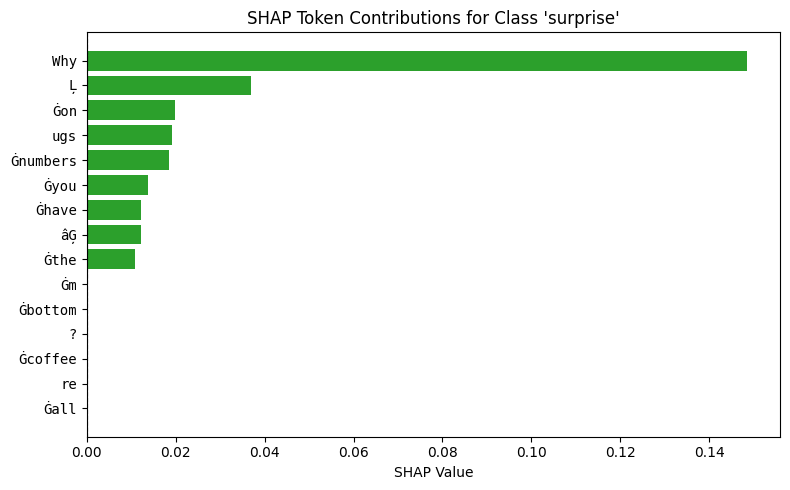

In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ============================
# 2) Φόρτωση tokenizer & μοντέλου
# ============================
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model     = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Συναρτήση για να παίρνει λίστα raw κειμένων → softmax πιθανότητες
def predict_proba(texts: list[str]) -> np.ndarray:
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs  = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# Ονόματα κλάσεων
id2label    = model.config.id2label
class_names = [id2label[i] for i in range(len(id2label))]
num_classes = len(class_names)

# ============================
# 3) Φόρτωση της πρώτης πρότασης
# ============================
import pandas as pd
CSV_PATH = "/content/test_sent_emo_cleaned_processed.csv"
df = pd.read_csv(CSV_PATH, encoding="utf-8")
first_utterance = df["Utterance"].iloc[0] if "Utterance" in df.columns else df.iloc[0,0]
print("Utterance 0:", first_utterance)

# Tokenize σε subwords (συμπεριλαμβάνονται ειδικά tokens "<s>","</s>")
enc_full  = tokenizer(first_utterance, return_attention_mask=False, add_special_tokens=True)
token_ids = enc_full["input_ids"]
tokens    = tokenizer.convert_ids_to_tokens(token_ids)
seq_len   = len(tokens)
print("BPE tokens:", tokens)
print("seq_len:", seq_len)

# ============================
# 4) Συναρτήση για KernelExplainer
# ============================
def mask_and_predict(mask_matrix: np.ndarray) -> np.ndarray:
    """
    mask_matrix: shape (n_samples, seq_len), τιμές {0,1}
      1 = διατηρώ subword, 0 = αντικαθιστώ με "[MASK]".
    Επιστρέφει: array shape (n_samples, num_classes) με τις softmax πιθανότητες.
    """
    texts = []
    for row in mask_matrix:
        out_tokens = []
        for keep, tok in zip(row, tokens):
            if keep == 1:
                out_tokens.append(tok)
            else:
                out_tokens.append(tokenizer.mask_token)  # "[MASK]"
        reconstructed = tokenizer.convert_tokens_to_string(out_tokens)
        texts.append(reconstructed)
    return predict_proba(texts)

# ============================
# 5) Δημιουργία πολλαπλών background samples
# ============================
num_background = 5
bg_masks = [np.ones(seq_len)]  # πάντα κρατάμε "όλον-ένα"  ως δείγμα αναφοράς
for _ in range(num_background):
    bg_masks.append(np.random.randint(0, 2, size=seq_len))
bg_mask = np.array(bg_masks)  # shape = (6, seq_len)
print("Background masks shape:", bg_mask.shape)

# ============================
# 6) Instantiate KernelExplainer
# ============================
explainer = shap.KernelExplainer(
    mask_and_predict,
    bg_mask,
    link="identity"
)

# ============================
# 7) Compute SHAP values για το "all-ones" μόνο
# ============================
# Δημιουργούμε ένα array shape=(1, seq_len) που είναι μονάδες
single_mask = np.ones((1, seq_len))

# Ζητάμε nsamples ~ 40× το seq_len για αξιοπιστία
nsamples = seq_len * 40
shap_values = explainer.shap_values(single_mask, nsamples=nsamples)

# shap_values μπορεί να έχει τις παρακάτω μορφές:
#  - list μήκους num_classes, όπου κάθε στοιχείο είναι array shape (1, seq_len)
#  - array shape (num_classes, 1, seq_len)
#  - array shape (1, seq_len, num_classes)
#  - array shape (1, seq_len) (single-output fallback)
arr = np.array(shap_values)

if isinstance(shap_values, list):
    # Κάθε στοιχείο της λίστας είναι (1, seq_len)
    shap_vals = np.vstack([sv[0] for sv in shap_values])  # → shape (num_classes, seq_len)
elif arr.ndim == 3 and arr.shape[1] == 1 and arr.shape[2] == seq_len:
    # shape == (num_classes, 1, seq_len)
    shap_vals = arr[:, 0, :]
elif arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1] == seq_len and arr.shape[2] == num_classes:
    # shape == (1, seq_len, num_classes) → transpose σε (num_classes, seq_len)
    shap_vals = arr[0].T
elif arr.ndim == 2 and arr.shape[0] == 1 and arr.shape[1] == seq_len:
    # single-output (έστω num_classes=1)
    shap_vals = arr  # θα είναι shape (1, seq_len)
else:
    raise ValueError(f"Unexpected shap_values shape: {arr.shape}")

print("shap_vals.shape (num_classes, seq_len):", shap_vals.shape)

# ============================
# 8) Προβλεπόμενη κλάση
# ============================
probs = predict_proba([first_utterance])[0]
pred_idx = np.argmax(probs)
pred_label = class_names[pred_idx]
print(f"Predicted class: '{pred_label}' (index {pred_idx})")

# Αν shap_vals έχει μόνο 1 γραμμή, τότε class_idx_for_shap = 0
if shap_vals.shape[0] == 1:
    class_idx_for_shap = 0
else:
    class_idx_for_shap = pred_idx

# ============================
# 9) Εκτύπωση όλων των SHAP τιμών (debug)
# ============================
print("\nΌλες οι SHAP τιμές για την κλάση:", class_idx_for_shap)
for tok, val in zip(tokens, shap_vals[class_idx_for_shap]):
    print(f"{tok:>8} → {val:.4f}")

# ============================
# 10) Φιλτράρισμα ειδικών tokens & επιλογή top-K
# ============================
filtered_tokens = []
filtered_shap   = []
for tok, val in zip(tokens, shap_vals[class_idx_for_shap]):
    if tok not in tokenizer.all_special_tokens:
        filtered_tokens.append(tok)
        filtered_shap.append(val)

filtered_tokens = np.array(filtered_tokens)
filtered_shap   = np.array(filtered_shap)

top_k = min(len(filtered_tokens), 15)
order = np.argsort(np.abs(filtered_shap))[-top_k:][::-1]

top_tokens = filtered_tokens[order]
top_values = filtered_shap[order]

# ============================
# 11) Σχεδίαση bar chart
# ============================
plt.figure(figsize=(8, 5))
y_pos = np.arange(len(top_tokens))

colors = ['tab:green' if v > 0 else 'tab:red' for v in top_values]
plt.barh(y_pos, top_values, color=colors, align='center')
plt.yticks(y_pos, top_tokens, fontsize=10, family='monospace')
plt.xlabel("SHAP Value")
plt.title(f"SHAP Token Contributions for Class '{pred_label}'")

# κάθετη γραμμή στο 0
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("plots/kernel_shap_single.png", bbox_inches="tight")

plt.show()



Utterance 0: Why do all you’re coffee mugs have numbers on the bottom?
shap_vals_per_class shape: (7, 128)
Predicted class: 'surprise' (index 2)


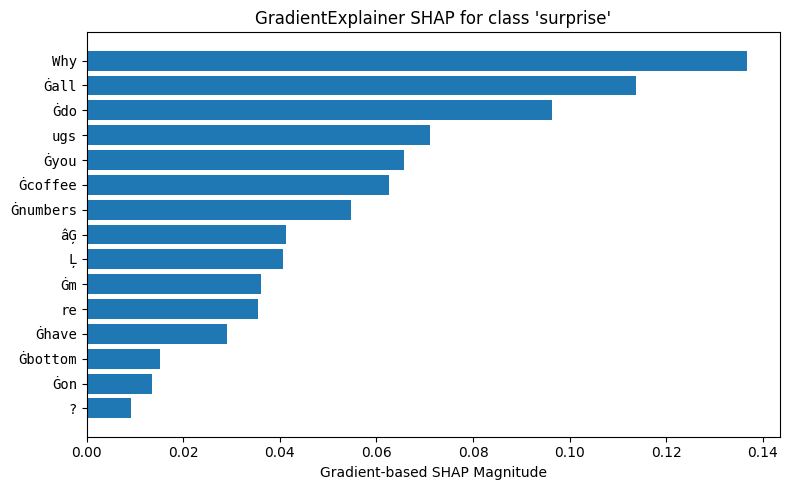

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ===============================================
# 1) Load tokenizer and Hugging Face model
# ===============================================
MODEL_NAME = "tae898/emoberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
hf_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
hf_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hf_model.to(device)

# ===============================================
# 2) Define the embedding‐based classifier wrapper
# ===============================================
class EmbeddingWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.roberta  = hf_model.roberta
        self.dropout  = hf_model.classifier.dropout
        self.dense    = hf_model.classifier.dense
        self.out_proj = hf_model.classifier.out_proj

    def forward(self, inputs_embeds, attention_mask):
        """
        inputs_embeds:    (batch_size, seq_len, hidden_dim)
        attention_mask:   (batch_size, seq_len)
        """
        outputs = self.roberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]   # [CLS] token pooling
        x = self.dropout(pooled)
        x = self.dense(x)
        x = torch.nn.functional.gelu(x)
        logits = self.out_proj(x)                     # (batch_size, num_labels)
        return logits

wrapped_model = EmbeddingWrapper(hf_model).to(device)
wrapped_model.eval()

# ===============================================
# 3) Create a two‐input nn.Module wrapper for SHAP
# ===============================================
class SHAPModel(torch.nn.Module):
    """
    Wraps a two‐input model (embeddings + attention_mask)
    into an nn.Module whose forward() accepts exactly those two tensors.
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, inputs_embeds, attention_mask):
        return self.base_model(inputs_embeds, attention_mask)

shap_model = SHAPModel(wrapped_model)

# ===============================================
# 4) Prepare the background dataset (20 random utterances)
# ===============================================
df = pd.read_csv("/content/test_sent_emo_cleaned_processed.csv", encoding="utf-8")
background_texts = df["Utterance"].sample(20, random_state=0).tolist()

enc_bg = tokenizer(
    background_texts,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids_bg      = enc_bg["input_ids"].to(device)       # (20, seq_len)
attention_mask_bg = enc_bg["attention_mask"].to(device)  # (20, seq_len)

# Obtain embeddings from the HF model’s embedding layer
emb_layer = hf_model.roberta.embeddings.word_embeddings
with torch.no_grad():
    inputs_embeds_bg = emb_layer(input_ids_bg)           # (20, seq_len, hidden_dim)

# SHAP’s “data” is now a list (or tuple) of two tensors
background = [inputs_embeds_bg, attention_mask_bg]

# ===============================================
# 5) Instantiate the GradientExplainer
# ===============================================
explainer = shap.GradientExplainer(
    shap_model,
    background
)

# ===============================================
# 6) Explain Utterance #0
# ===============================================
first_text = df["Utterance"].iloc[0]
print("Utterance 0:", first_text)

enc0 = tokenizer(
    first_text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids0      = enc0["input_ids"].to(device)       # (1, seq_len)
attention_mask0 = enc0["attention_mask"].to(device)  # (1, seq_len)

with torch.no_grad():
    inputs_embeds0 = emb_layer(input_ids0)            # (1, seq_len, hidden_dim)

# SHAP expects the same two‐element list for a single example:
test_input = [inputs_embeds0, attention_mask0]

# Compute SHAP values:
#   raw_shap is a list of length = number of model inputs (2 here).
raw_shap = explainer.shap_values(test_input)

# -----------------------------------------------
# 7) Extract only the embedding‐dimension attributions
# -----------------------------------------------
# raw_shap[0] corresponds to attributions for inputs_embeds:
#   shape = (1, seq_len, hidden_dim, num_labels)
shap_emb = raw_shap[0]            # NumPy array
shap_emb = shap_emb[0]            # drop batch dim → shape = (seq_len, hidden_dim, num_labels)

num_labels = hf_model.config.num_labels
seq_len, hidden_dim, nl = shap_emb.shape
assert nl == num_labels, "Mismatch between shap_emb last axis and model.num_labels"

# For each class c, compute L2 norm over hidden_dim → scalar per token
shap_vals_per_class = []
for c in range(num_labels):
    # shap_emb[:,:,c] has shape (seq_len, hidden_dim)
    vals_c = shap_emb[:, :, c]
    token_attr = np.linalg.norm(vals_c, axis=1)  # (seq_len,)
    shap_vals_per_class.append(token_attr)

shap_vals_per_class = np.vstack(shap_vals_per_class)  # shape = (num_labels, seq_len)
print("shap_vals_per_class shape:", shap_vals_per_class.shape)

# ===============================================
# 8) Identify the predicted class and the top tokens
# ===============================================
with torch.no_grad():
    logits0 = wrapped_model(inputs_embeds0, attention_mask0)    # (1, num_labels)
    probs0 = torch.softmax(logits0, dim=-1)[0].cpu().numpy()    # (num_labels,)

pred_idx   = np.argmax(probs0)
pred_label = hf_model.config.id2label[pred_idx]
print(f"Predicted class: '{pred_label}' (index {pred_idx})")

# Convert input IDs back to tokens (including special tokens)
tokens_bpe = tokenizer.convert_ids_to_tokens(input_ids0[0].cpu().numpy())

filtered_tokens = []
filtered_shap   = []
for tok, attr in zip(tokens_bpe, shap_vals_per_class[pred_idx]):
    if tok not in tokenizer.all_special_tokens:
        filtered_tokens.append(tok)
        filtered_shap.append(attr)

filtered_tokens = np.array(filtered_tokens)
filtered_shap   = np.array(filtered_shap)

# Choose top‐K tokens (up to 15)
top_k = min(len(filtered_tokens), 15)
order = np.argsort(filtered_shap)[-top_k:][::-1]

top_tokens = filtered_tokens[order]
top_values = filtered_shap[order]

# ===============================================
# 9) Plot a horizontal bar chart of the top tokens
# ===============================================
plt.figure(figsize=(8, 5))
y_pos = np.arange(len(top_tokens))

colors = ['tab:blue'] * len(top_values)
plt.barh(y_pos, top_values, color=colors, align='center')
plt.yticks(y_pos, top_tokens, fontsize=10, family='monospace')
plt.xlabel("Gradient‐based SHAP Magnitude")
plt.title(f"GradientExplainer SHAP for class '{pred_label}'")

plt.gca().invert_yaxis()  # highest‐importance at the top
plt.tight_layout()
plt.savefig("plots/gradshap_instance.png", bbox_inches="tight")

plt.show()



Top 20 tokens with highest mean SHAP influence for 'surprise':
  Push             0.1497
  Why              0.1387
  know             0.1270
  all              0.1145
  Oh               0.1111
  ball             0.1072
  !                0.0970
  Let              0.0842
  what             0.0801
  Y                0.0787
  Come             0.0746
  Lydia            0.0658
  Monica           0.0653
  do               0.0616
  ugs              0.0605
  was              0.0590
  just             0.0581
  coffee           0.0580
  so               0.0523
  âĢĶ              0.0515


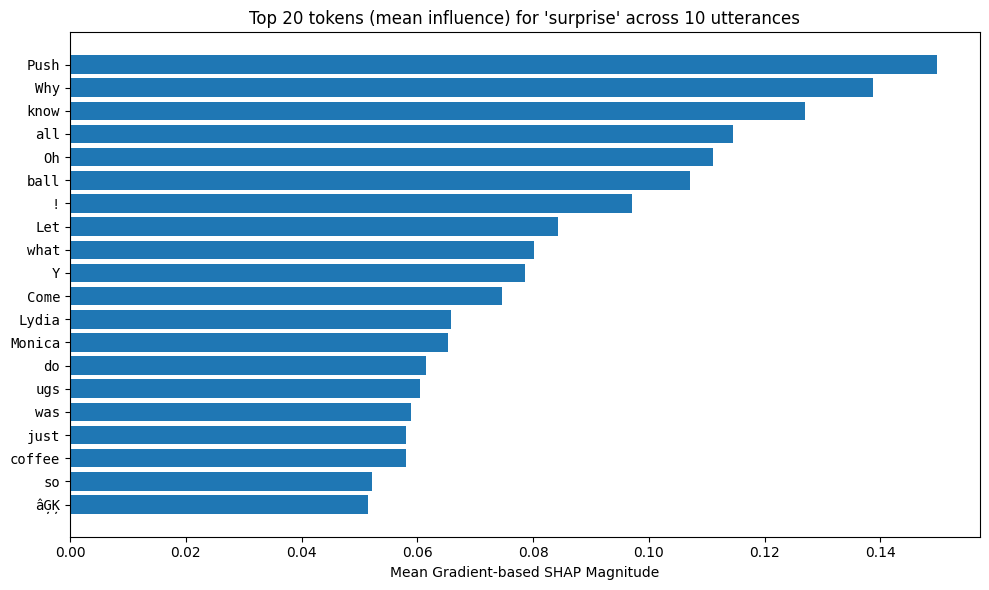

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ===============================================
# 1) Load tokenizer and Hugging Face model
# ===============================================
MODEL_NAME = "tae898/emoberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
hf_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
hf_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hf_model.to(device)

# ===============================================
# 2) Define the embedding‐based classifier wrapper
# ===============================================
class EmbeddingWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.roberta  = hf_model.roberta
        self.dropout  = hf_model.classifier.dropout
        self.dense    = hf_model.classifier.dense
        self.out_proj = hf_model.classifier.out_proj

    def forward(self, inputs_embeds, attention_mask):
        """
        inputs_embeds:    (batch_size, seq_len, hidden_dim)
        attention_mask:   (batch_size, seq_len)
        """
        outputs = self.roberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]   # <s> token pooling
        x = self.dropout(pooled)
        x = self.dense(x)
        x = torch.nn.functional.gelu(x)
        logits = self.out_proj(x)                     # (batch_size, num_labels)
        return logits

wrapped_model = EmbeddingWrapper(hf_model).to(device)
wrapped_model.eval()

# ===============================================
# 3) Wrap it in a two‐input nn.Module for SHAP
# ===============================================
class SHAPModel(torch.nn.Module):
    """
    Wraps a two‐input model (embeddings + attention_mask)
    into an nn.Module whose forward() accepts exactly those two tensors.
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, inputs_embeds, attention_mask):
        return self.base_model(inputs_embeds, attention_mask)

shap_model = SHAPModel(wrapped_model)

# ===============================================
# 4) Load dataset and prepare background
# ===============================================
df = pd.read_csv("/content/test_sent_emo_cleaned_processed.csv", encoding="utf-8")

# Use the first 200 utterances for explanation
num_to_explain = 10
if len(df) < num_to_explain:
    raise ValueError(f"DataFrame has only {len(df)} rows (<{num_to_explain}).")

# Pick 20 random utterances (can be from among the first 200 or the whole set)
background_texts = df["Utterance"].sample(20, random_state=0).tolist()
enc_bg = tokenizer(
    background_texts,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids_bg      = enc_bg["input_ids"].to(device)       # (20, seq_len)
attention_mask_bg = enc_bg["attention_mask"].to(device)  # (20, seq_len)

# Obtain embeddings for background
emb_layer = hf_model.roberta.embeddings.word_embeddings
with torch.no_grad():
    inputs_embeds_bg = emb_layer(input_ids_bg)           # (20, seq_len, hidden_dim)

# SHAP background must be a list of two tensors
background = [inputs_embeds_bg, attention_mask_bg]

# ===============================================
# 5) Instantiate the GradientExplainer
# ===============================================
explainer = shap.GradientExplainer(
    shap_model,
    background
)

# ===============================================
# 6) Specify target emotion and map to index
# ===============================================
target_emotion = "surprise"  # change to any valid label
label_to_id = {lab.lower(): idx for idx, lab in hf_model.config.id2label.items()}
if target_emotion not in label_to_id:
    raise ValueError(
        f"Label '{target_emotion}' not found; available labels: {list(hf_model.config.id2label.values())}"
    )
target_idx = label_to_id[target_emotion]

# ===============================================
# 7) Loop over the first 200 utterances and collect token‐wise SHAP scores
# ===============================================
token_scores = {}  # mapping from token string to list of SHAP scores

for i in range(num_to_explain):
    utterance = df["Utterance"].iloc[i]
    enc = tokenizer(
        utterance,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    input_ids = enc["input_ids"].to(device)         # (1, seq_len)
    attention_mask = enc["attention_mask"].to(device)  # (1, seq_len)

    with torch.no_grad():
        inputs_embeds = emb_layer(input_ids)        # (1, seq_len, hidden_dim)

    test_input = [inputs_embeds, attention_mask]

    raw_shap = explainer.shap_values(test_input)
    # raw_shap[0]: shape (1, seq_len, hidden_dim, num_labels)
    shap_emb = raw_shap[0][0]  # drop batch dim → (seq_len, hidden_dim, num_labels)

    # Compute L2 norm over hidden_dim for the target class → (seq_len,)
    seq_len, hidden_dim, num_labels = shap_emb.shape
    vals_c = shap_emb[:, :, target_idx]            # (seq_len, hidden_dim)
    token_attrs = np.linalg.norm(vals_c, axis=1)    # (seq_len,)

    # Convert input IDs → subword tokens
    tokens_bpe = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    # Clean tokens and accumulate scores
    for tok, score in zip(tokens_bpe, token_attrs):
        clean_tok = tok.lstrip("Ġ")
        if clean_tok and (clean_tok not in tokenizer.all_special_tokens):
            token_scores.setdefault(clean_tok, []).append(score)

# ===============================================
# 8) Compute mean SHAP score per token across all utterances
# ===============================================
mean_scores = {tok: np.mean(scores) for tok, scores in token_scores.items()}

# Convert to sorted list of (token, mean_score) descending
sorted_tokens = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)

# Select top K tokens
top_k = 20
top_tokens = sorted_tokens[:top_k]

# ===============================================
# 9) Print and plot the top tokens by mean influence
# ===============================================
print(f"Top {top_k} tokens with highest mean SHAP influence for '{target_emotion}':")
for tok, ms in top_tokens:
    print(f"  {tok:15s}  {ms:.4f}")

# Plot
tokens_plot = [tok for tok, _ in top_tokens]
scores_plot = [ms for _, ms in top_tokens]

plt.figure(figsize=(10, 6))
y_pos = np.arange(len(tokens_plot))
plt.barh(y_pos, scores_plot, color='tab:blue', align='center')
plt.yticks(y_pos, tokens_plot, fontsize=10, family='monospace')
plt.xlabel("Mean Gradient‐based SHAP Magnitude")
plt.title(f"Top {top_k} tokens (mean influence) for '{target_emotion}' across {num_to_explain} utterances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"plots/gradshap_top_{top_k}.png", bbox_inches="tight")
plt.show()


In [ ]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.2 MB/s eta 0:00:00


In [ ]:
from bertviz import head_view, model_view

def visualize_attention(model, tokenizer, sample_text, stage="Pre Fine-Tuning"):
    # Ensure the model outputs attentions
    model.config.output_attentions = True
    model.eval()
    device = next(model.parameters()).device
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions  # Tuple of attention tensors for each layer
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    print(f"\n--- {stage} Attention Visualization (Head View) ---")
    head_view(attentions, tokens)

    print(f"\n--- {stage} Attention Visualization (Model View) ---")
    model_view(attentions, tokens)


In [ ]:
import torch
MODEL_NAME = "tae898/emoberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
# Visualize attention before fine-tuning
pre_sample_text = df["Utterance"].iloc[6]
visualize_attention(model, tokenizer, pre_sample_text, stage="Pre Fine-Tuning")
model.config.output_attentions = True



--- Pre Fine-Tuning Attention Visualization (Head View) ---


<IPython.core.display.Javascript object>


--- Pre Fine-Tuning Attention Visualization (Model View) ---


<IPython.core.display.Javascript object>